# Notebook for making movies of FlyOver trials
### Loads data from a single VR trial at a time

In [1]:
import numpy as np
import pandas as pd 
    
from os import mkdir, walk, getcwd
from os.path import sep, exists
from sys import path, exit
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

import imageio

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-1])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleTwoObjVROptogenTrialAnalysis,\
        singleVROptogenTrialAnalysis
from flyVR.flyVRAnalysis.flyVR_oneTrialBasicAnalysis import singleVRTrialAnalysis

from plottingUtilities.basicPlotting import makeNestedPlotDirectory, myAxisTheme,_myAccentList

from flyVR.utilities.loadObjectCoords import loadObjectCoordIdentities

from trajectoryAnalysis.trajectoryDerivedParams import relationToObject

from plottingUtilities.objectPreferencePlots import countvisits

%matplotlib inline 

In [2]:
# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
datafile = askopenfilename(initialdir=baseDir,
                       title='Select experiment file')
root.update()
root.destroy()

In [3]:
dataDir = sep.join(datafile.split(sep)[:-1])+sep
fileName = datafile.split(sep)[-1]

analysisDir = sep.join(dataDir) + sep + 'analysis' + sep

print('Analysing the following file:\n')
print(fileName)

Analysing the following file:

singleObjectForest_visualClutter_fog120-360_WTB_m05_A_6-7d_5minMovie_180614174448.txt


In [4]:
# run basic analysis?
rerunbasicanalysis = 'n'

In [5]:
flyID = 'm05A'
genotype = 'WTB'
trial = 1
trialtype = 'farfog'

#### Make sure to adjust single trial processing script depending on data used for the movie

In [6]:
# Generate data frame with data
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','starvation','moving'] + keylist
fly_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)
 
vTransTH = 2 #mm/s

# Run single trial analysis on each file in folder .....................................................
if rerunbasicanalysis == 'y':
    returnVal = singleVRTrialAnalysis(dataDir + fileName)
    print('Ran analysis, now loading saved *.npy file.')
    FODatLoad = np.load(dataDir + fileName[:-3] + 'npy')[()]
else:
    print('Loading saved *.npy file.')
    FODatLoad = np.load(dataDir + fileName[:-3] + 'npy')[()]

vTrans = np.copy(FODatLoad['transVelo'])
moving = vTrans >= vTransTH

FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
FODatLoad_df.insert(0, 'flyID', flyID)
FODatLoad_df.insert(1, 'trial', trial)
FODatLoad_df.insert(2, 'trialtype', trialtype)
#FODatLoad_df.insert(3, 'reinforcement', rZones)
FODatLoad_df.insert(5, 'moving', moving)

fly_df = fly_df.append(FODatLoad_df)


Loading saved *.npy file.


In [7]:
fly_df = fly_df[keylistLong]

fly_df['flyID'] = fly_df['flyID'].astype('category')
fly_df['trial'] = fly_df['trial'].astype('category')
fly_df['trialtype'] = fly_df['trialtype'].astype('category')
fly_df['reinforcement'] = fly_df['reinforcement'].astype('category')

fly_df.head()

,flyID,trial,trialtype,reinforcement,starvation,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,m05A,1.0,farfog,NaN,NaN,1.0,-0.000004,0.000000,0.000000,206326.140694,6932.290,NaN,-6810.660,NaN,NaN
1,m05A,1.0,farfog,NaN,NaN,0.0,-0.000004,0.000000,0.050009,0.000000,-424.978,NaN,423.758,NaN,NaN
2,m05A,1.0,farfog,NaN,NaN,0.0,-0.000004,0.000000,0.100019,0.000000,-424.978,NaN,423.758,NaN,NaN
3,m05A,1.0,farfog,NaN,NaN,0.0,-0.000004,0.000000,0.150028,0.000000,-424.978,NaN,423.758,NaN,NaN
4,m05A,1.0,farfog,NaN,NaN,1.0,-0.000004,0.088805,0.200038,2.898076,-424.978,NaN,423.758,NaN,NaN


In [8]:
flyIDallarray = np.asarray(fly_df['flyID']).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))
flyIDs

['m05A']

### Settings

In [9]:
# Two object reinforcement test
rZoneState = ['off','on','off']
visibilityState = ['visible','visible','visible']
groundPlane = ['texture','texture','texture']
trialName = ['pre','train','post']
gridSize = 60.0

fps = 20

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'


visitRad = 15

# for 2-object world
coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]

### Helper functions

In [10]:
import matplotlib.patches as patches

def plotBodyAngle(ax, x, y, angle, markerColor, alphaVal, arrowScale):
    newArrow = patches.FancyArrow(x, y, np.cos(angle).squeeze()*arrowScale, np.sin(angle).squeeze()*arrowScale,
                                  width=0.25, head_width=0.25,
                                  edgecolor=markerColor, facecolor=markerColor, alpha=alphaVal)
    ax.add_patch(newArrow)

## Load basler movie

In [11]:
vidname = 'visualClutter_WTBm05A_120-360fog_5min_40Hz.mov'

In [12]:
movDir = sep.join(dataDir.split(sep)[:-3])+sep
print(movDir)

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/visualClutter/movie/fog120-360-5min/


In [13]:
vid = imageio.get_reader(movDir+vidname,  'ffmpeg')

In [14]:
# select frames
trialstart = 80
framerate = 26#38.43
tstart = 1
tend = 1.1
slctframes_basler = np.linspace(int(trialstart+tstart*framerate*60),int(tend*60*framerate),int(20*60*(tend-tstart)))

#### Select and save out single frames

In [84]:
try:
    mkdir(movDir + 'movieMaterial/')
except:
    print('directory already exists')
try:
    mkdir(movDir + 'movieMaterial/flyframes/')
except:
    print('directory already exists')

for num in slctframes_basler:
    num=int(num)
    frameName=str(num)
    image = vid.get_data(num)
    fig,flyplt = plt.subplots(figsize=(10,5))
    fig.suptitle('frame {}'.format(num), fontsize=15)
    flyplt.imshow(image)
    flyplt.get_xaxis().set_visible(False)
    flyplt.get_yaxis().set_visible(False)
    
    fig.savefig(movDir + 'movieMaterial/flyframes/'+ genotype+'_ballfly_fly'+ flyID+'_frame'+frameName.zfill(5)+'.jpeg', format='jpeg')
    
    plt.close("all")

directory already exists


## Make movie of trajectory (raw trajectory and trajectory in miniarena)

In [56]:
# Select frame range and set color range
    
# select frames
trialstart = 0
framerate = 20
tstart = 1
tend = 3
frameRange_traj = np.linspace(int(trialstart+tstart*framerate*60),int(tend*60*framerate),int(20*60*(tend-tstart))).astype('int')

# color code for time
cNorm  = colors.Normalize(vmin=0, vmax=len(frameRange_traj))
mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
timeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

### Full trace

In [57]:
try:
    mkdir(movDir + 'movieMaterial/')
except:
    print('directory already exists')
try:
    mkdir(movDir + 'movieMaterial/fulltrajFrames/')
except:
    print('directory already exists')

directory already exists
directory already exists


In [58]:
coordFile = 'singleObjectForest_rZones_1cm4cmCone_12cmHex_large.coords'

# get object positions
visibleObjectCoords, visibleObjectName, invisibleObjectCoords, origin = loadObjectCoordIdentities(movDir, coordFile)
coneShape = np.asarray([bool('Cone' in objName) for objName in visibleObjectName])
cyliShape = np.asarray([bool('Cyli' in objName) for objName in visibleObjectName])

titleString = 'raw trajectory'

In [59]:
xPos = fly_df['xPos'].values[frameRange_traj]
yPos = fly_df['yPos'].values[frameRange_traj]
angleFly = fly_df['headingAngle'].values[frameRange_traj]
evTrial = fly_df['rEvents'].values[frameRange_traj]
    
xlimval = (np.min(xPos), np.max(xPos))
ylimval = (np.min(yPos), np.max(yPos))

(-15.287099999999999, 301.89743807301215)

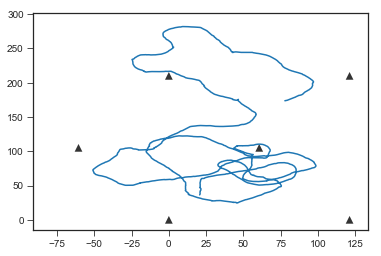

In [60]:
# check if things look good:
plt.plot(xPos,yPos)
plt.scatter(visibleObjectCoords[coneShape, 0], visibleObjectCoords[coneShape, 1], 60, alpha=0.8,
               facecolors='black', edgecolors='none', marker = '^')
plt.scatter(visibleObjectCoords[cyliShape, 0], visibleObjectCoords[cyliShape, 1], 60, alpha=0.8,
               facecolors='black', edgecolors='none', marker = 's')
plt.xlim(xlimval[0]-40,xlimval[1]+35)
plt.ylim(ylimval[0]-40,ylimval[1]+20)

In [187]:
for i, frame in enumerate(frameRange_traj):
    frameName = str(frame)
    
    frameFig, framePlt = plt.subplots(1,1, figsize=(5,5))
    
    xpos = xPos[i]
    ypos = yPos[i]
    
    #plot past trajectory
    framePlt.scatter(xPos[0:i],yPos[0:i],s=3,c=np.arange(0,i),
                 cmap=mycmap, vmin=0, vmax=len(frameRange_traj), alpha=0.5)
    
    # plot position
    plotBodyAngle(framePlt, xpos, ypos, angleFly[i],'black', 0.6, 12)
    framePlt.plot(xpos,ypos,'.',color=timeCMap.to_rgba(i),markersize=16)
        
    if(evTrial[i]>0):
        framePlt.plot(xpos,ypos,'.',markersize=15,color='darkred')

    #plot objects
    framePlt.scatter(visibleObjectCoords[coneShape, 0], visibleObjectCoords[coneShape, 1], 60, alpha=0.8,
               facecolors='black', edgecolors='none', marker = '^')
    framePlt.scatter(visibleObjectCoords[cyliShape, 0], visibleObjectCoords[cyliShape, 1], 60, alpha=0.8,
               facecolors='black', edgecolors='none', marker = 's')
    
    framePlt.set_xlim(xlimval[0]-40,xlimval[1]+35)
    framePlt.set_ylim(ylimval[0]-40,ylimval[1]+20)
    framePlt.set_aspect('equal')
    
    framePlt.set_title(titleString)
    myAxisTheme(framePlt)

        
    frameFig.savefig(movDir + 'movieMaterial/fulltrajFrames/'+ genotype+'_fulltraj_fly'+
                     flyID +'_frame'+frameName.zfill(5)+'.jpeg', format='jpeg')
    
    plt.close("all")

### Collapsed trace
#### Single object forest

In [61]:
try:
    mkdir(movDir + 'movieMaterial/')
except:
    print('directory already exists')
try:
    mkdir(movDir + 'movieMaterial/trajFrames/')
except:
    print('directory already exists')

directory already exists
directory already exists


In [62]:
xPosMA = fly_df['xPosInMiniarena'].values[frameRange_traj]
yPosMA = fly_df['yPosInMiniarena'].values[frameRange_traj]
angleFly = fly_df['headingAngle'].values[frameRange_traj]
evTrial = fly_df['rEvents'].values[frameRange_traj]

dist2LM = np.hypot(xPosMA, yPosMA)

# count visits
entries,exits,visitT,entryTime,exitTime = countvisits(dist2LM,visitRad)
sum(entries)

6.0

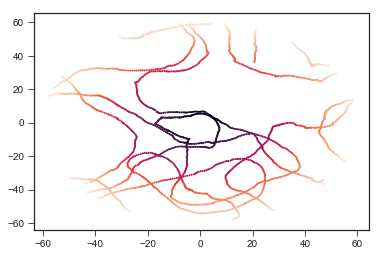

In [63]:
# check if things look good:
plt.scatter(xPosMA,yPosMA,s=1,c=dist2LM)

In [214]:
for i, frame in enumerate(frameRange_traj):
    frameName = str(frame)
    
    visitFig, visitPlt = plt.subplots(1,1, figsize=(5,5))
    
    xpos = xPosMA[i]
    ypos = yPosMA[i]
    
    #plot past trajectory
    visitPlt.scatter(xPosMA[0:i],yPosMA[0:i],s=3,c=np.arange(0,i),
                 cmap=mycmap, vmin=0, vmax=len(frameRange_traj), alpha=0.5)
    
    # plot position
    plotBodyAngle(visitPlt, xpos, ypos, angleFly[i],'black', 0.6, 6)
    visitPlt.plot(xpos,ypos,'.',color=timeCMap.to_rgba(i),markersize=16)
        
    if(evTrial[i]>0):
        visitPlt.plot(xpos,ypos,'.',markersize=15,color='darkred')

    if(entries[i]>0):
        visitPlt.plot(xpos,ypos,'o',markersize=17, color=coneColor)

    visitPlt.plot(0, 0, marker='^', markersize=16, alpha=0.8, color='black')

    visitPlt.set_xlim(-65,65)
    visitPlt.set_ylim(-65,65)
    visitPlt.set_aspect('equal')
    
    visitPlt.set_title(trialtype)
    myAxisTheme(visitPlt)

        
    visitFig.savefig(movDir + 'movieMaterial/trajFrames/'+ genotype +'_collapsedTrace_fly'+
                     flyID +'_frame'+frameName.zfill(5)+'.jpeg', format='jpeg')
    
    plt.close("all")

#### 2-object forest

NameError: name 'xPosTrial' is not defined

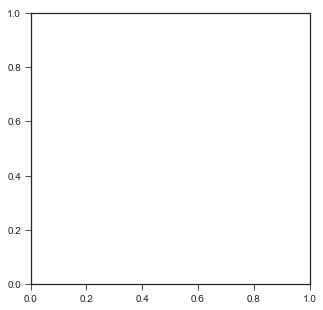

In [92]:
for frame in frameRange:
    frameName = str(frame)
    
    visitFig = plt.figure(figsize=(5,5))
    visitPlt = visitFig.add_subplot(111)
    
    xpos = xPosTrial[frame]
    ypos = yPosTrial[frame]
    
    # compute distance to each landmark
    dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
    dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
    dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
    dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

    # compute distance to closest landmark
    dist2closestCone = np.minimum(dist2cone1,dist2cone2)
    dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

    entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
    entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
    
    #plot past trajectory
    visitPlt.scatter(xPosTrial[frameRange[0]:frame],yPosTrial[frameRange[0]:frame],s=3,c=np.arange(frameRange[0],frame),
                 cmap=mycmap, vmin=frameRange[0], vmax=frameRange[-1], alpha=0.5)
    
    # plot position
    plotBodyAngle(visitPlt, xpos, ypos, angleFly[frame],'black', 0.6, 6)
    visitPlt.plot(xpos,ypos,'.',color=timeCMap.to_rgba(frame),markersize=16)

    if(entriesCone[frame]>0):
        visitPlt.plot(xpos,ypos,'o',markersize=20, color=coneColor)
    
    if(entriesCyli[frame]>0):
        visitPlt.plot(xpos,ypos,'o',markersize=20, color=cyliColor)
        
    if(evTrial[frame]>0):
        visitPlt.plot(xpos,ypos,'.',markersize=15,color='darkred')

    visitPlt.plot(cyliCoords[0][0], cyliCoords[0][1], marker='s', markersize=11, alpha=0.8, color='black')
    visitPlt.plot(coneCoords[0][0], coneCoords[0][1], marker='^', markersize=14, alpha=0.8, color='black')
    visitPlt.plot(coneCoords[1][0], coneCoords[1][1], marker='^', markersize=14, alpha=0.8, color='black')
    visitPlt.plot(cyliCoords[1][0], cyliCoords[1][1], marker='s', markersize=11, alpha=0.8, color='black')

    visitPlt.set_xlim(0,120)
    visitPlt.set_ylim(-60,60)
    visitPlt.set_aspect('equal')
    
    visitPlt.set_title(trialtype)
    myAxisTheme(visitPlt)

        
    visitFig.savefig(analysisDir + 'movieMaterial/fulltrajFrames/'+ genotype +'_collapsedTrace_fly'+
                     flyID +'_frame'+frameName.zfill(5)+'.jpeg', format='jpeg')
    
    plt.close("all")

## Make combined movie: trajectory + fly + VR

In [160]:
#vidname = 'visualClutter_WTBm05A_120-360fog_5min_40Hz.mov'

try:
    mkdir(movDir + 'movieMaterial/')
except:
    print('directory already exists')
try:
    mkdir(movDir + 'movieMaterial/traj-fly-VR/')
except:
    print('directory already exists')
    
tstart = 1
tend = 3

framerateCombi = 20

frameRange = range(0,(tend-tstart)*framerateCombi*60+1)

directory already exists
directory already exists


#### single object forest

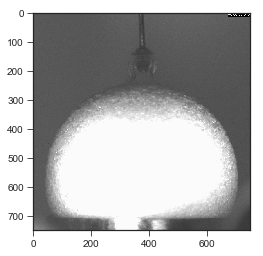

In [161]:
# (1) Fly video
vid = imageio.get_reader(movDir+vidname,  'ffmpeg')
# select frames
trialstart = 75
framerateBasler = 26.5

slctframes_basler = np.linspace(int(trialstart+tstart*framerateBasler*60),\
                                int(tend*60*framerateBasler),1+int(framerateCombi*60*(tend-tstart)))
#test
image = vid.get_data(trialstart)
plt.imshow(image)

In [167]:
int((tstart-1)*60*framerateVR)

0

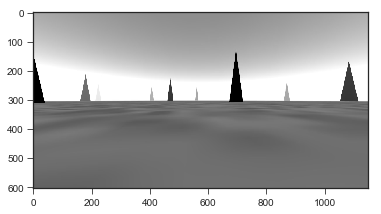

In [162]:
# (2) VR video
vrviddir = 'singleObjectForest_visualClutter_fog120-360_WTB_m05_A_6-7d_5minMovie_180614174448_movie'
vrvidname = 'flyvr_movie_120deg_30Hz.mp4'

# movie made from min 1 to 3
framerateVR = 30.0
slctframes_vr = np.linspace(int((tstart-1)*60*framerateVR),int((tend-1)*60*framerateVR),1+int(framerateCombi*60*(tend-tstart)))
#slctframes_vr = np.linspace(int(tstart*60*framerateVR),int(tend*60*framerateVR),int(framerateCombi*60*(tend-tstart)))

# test
vidVR = imageio.get_reader(movDir+vrviddir+sep+vrvidname,  'ffmpeg')
image = vidVR.get_data(0)
plt.imshow(image)

In [163]:
print(len(slctframes_basler))
print(slctframes_basler[-1])

print(len(slctframes_vr))
print(slctframes_vr[-1])

print(len(frameRange))
print(frameRange[-1])

2401
4770.0
2401
3600.0
2401
2400


In [164]:
# (3) Settings for trajectory plot
framerateTraj = 20
slctframes_traj = np.linspace(int(tstart*framerateTraj*60),
                              int(tend*60*framerateTraj),1+int(framerateCombi*60*(tend-tstart)))

slctframes_traj_ind = np.round(slctframes_traj).astype(int)

# color code for time
cNorm  = colors.Normalize(vmin=0, vmax=len(frameRange))
mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
timeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

# extract data
xPos = fly_df['xPos'].values[slctframes_traj_ind]
yPos = fly_df['yPos'].values[slctframes_traj_ind]
angleFly = fly_df['headingAngle'].values[slctframes_traj_ind]
evTrial = fly_df['rEvents'].values[slctframes_traj_ind]

xlimval = (np.min(xPos), np.max(xPos))
ylimval = (np.min(yPos), np.max(yPos))

xPosMA = fly_df['xPosInMiniarena'].values[slctframes_traj_ind]
yPosMA = fly_df['yPosInMiniarena'].values[slctframes_traj_ind]

dist2LM = np.hypot(xPosMA, yPosMA)

# count visits
entries,exits,visitT,entryTime,exitTime = countvisits(dist2LM,visitRad)

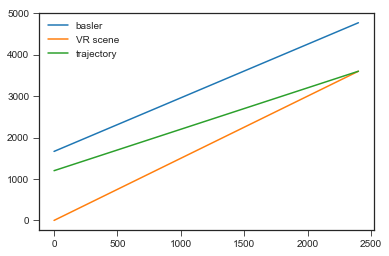

In [165]:
plt.plot(frameRange,slctframes_basler)
plt.plot(frameRange,slctframes_vr)
plt.plot(frameRange,slctframes_traj)
plt.legend(['basler','VR scene','trajectory']);

In [166]:
# (4) Plot frames                       
for i, frame in enumerate(frameRange):
    frameName = str(i)
    
    frameFig = plt.figure(figsize=(14,10))
    gs = gridspec.GridSpec(2,2, width_ratios=[1,1.5])
    
    
    # (A) raw trace
    xpos = xPos[i]
    ypos = yPos[i]
    
    #plot past trajectory
    framePlt = frameFig.add_subplot(gs[0,0])
    framePlt.scatter(xPos[0:i],yPos[0:i],s=3,c=np.arange(0,i),cmap=mycmap, vmin=0, vmax=len(frameRange), alpha=0.5)
    
    # plot position
    plotBodyAngle(framePlt, xpos, ypos, angleFly[i],'black', 0.6, 10)
    framePlt.plot(xpos,ypos,'.',color=timeCMap.to_rgba(i),markersize=16)
        
    if(evTrial[i]>0):
        framePlt.plot(xpos,ypos,'.',markersize=15,color='darkred')

    #plot objects
    framePlt.scatter(visibleObjectCoords[coneShape, 0], visibleObjectCoords[coneShape, 1], 60, alpha=0.8,
               facecolors='black', edgecolors='none', marker = '^')
    framePlt.scatter(visibleObjectCoords[cyliShape, 0], visibleObjectCoords[cyliShape, 1], 60, alpha=0.8,
               facecolors='black', edgecolors='none', marker = 's')
    
    framePlt.set_xlim(xlimval[0]-45,xlimval[1]+45)
    framePlt.set_ylim(ylimval[0]-70,ylimval[1]+70)
    framePlt.set_aspect('equal')
    
    framePlt.plot([xlimval[0]-40, xlimval[0]+10],[ylimval[0]-50, ylimval[0]-50], color='k', linewidth=2)
    framePlt.text(xlimval[0]-35, ylimval[0]-47, '50 mm', fontsize=14)
    
    framePlt.set_title('Raw trajectory',fontsize=14)
    framePlt.axis('off')
    
    
    # (B) collapsed trace
    #plot past trajectory
    framePlt = frameFig.add_subplot(gs[1,0])
    framePlt.scatter(xPosMA[0:i],yPosMA[0:i],s=3,c=np.arange(0,i), cmap=mycmap, vmin=0, \
                     vmax=len(frameRange), alpha=0.5)
    
    # plot position
    plotBodyAngle(framePlt, xPosMA[i],yPosMA[i], angleFly[i],'black', 0.6, 6)
    framePlt.plot(xPosMA[i],yPosMA[i],'.',color=timeCMap.to_rgba(i),markersize=16)

    if(entries[i]>0):
        framePlt.plot(xPosMA[i],yPosMA[i],'o',markersize=20, color=coneColor)
        
    if(evTrial[i]>0):
        framePlt.plot(xPosMA[i],yPosMA[i],'.',markersize=15,color='darkred')

    framePlt.plot(0,0, marker='^', markersize=14, alpha=0.6, color='black')

    framePlt.set_xlim(-65,65)
    framePlt.set_ylim(-65,65)
    framePlt.set_aspect('equal')
    
    framePlt.set_title('Collapsed trajectory', fontsize=14)
    framePlt.axis('off')
    
    # (C) plot frame from fly video
    framePlt = frameFig.add_subplot(gs[1,1])
    num=int(np.round(slctframes_basler[i]))
    image = vid.get_data(num)
    framePlt.set_title(' Fly video', fontsize=14)
    framePlt.imshow(image)
    framePlt.invert_xaxis()
    framePlt.get_xaxis().set_visible(False)
    framePlt.get_yaxis().set_visible(False)
    
    # (D) plot frame from VR video
    framePlt = frameFig.add_subplot(gs[0,1])
    num=int(np.round(slctframes_vr[i]))
    vidVR = imageio.get_reader(movDir+vrviddir+sep+vrvidname,  'ffmpeg')
    image = vidVR.get_data(num)
    framePlt.set_title('Rendered VR scene', fontsize=14)
    framePlt.imshow(image)
    framePlt.get_xaxis().set_visible(False)
    framePlt.get_yaxis().set_visible(False)
    
    frameFig.tight_layout()
    frameFig.savefig(movDir + 'movieMaterial/traj-fly-VR/'+ genotype
                       +'_all_fly'+ flyID +'_frame'+frameName.zfill(5)+'.jpeg', format='jpeg')
    
    plt.close("all")



#### Two-object forest

In [162]:
# select frames for fly video
vid = imageio.get_reader(movDir+vidname,  'ffmpeg')
trialstart = 98
framerate = 45.5#38.43
slctframes = np.linspace(int(trialstart+tstart*framerate*60),int(tend*60*framerate),int(20*60*(tend-tstart)))

# select frames for VR video
frameratevr = 46
vrslctframes = np.linspace(int(tstart*60*frameratevr),int(tend*60*frameratevr),int(20*60*(tend-tstart)))

# color code for time
cNorm  = colors.Normalize(vmin=0, vmax=len(frameRange))
mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
timeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

xlimval = (np.min(xPos[frameRange]), np.max(xPos[frameRange]))
ylimval = (np.min(yPos[frameRange]), np.max(yPos[frameRange]))
                                  
for frame in frameRange:#int(len(timeTrial)*0.1)):
    frameName = str(frame)
    
    frameFig = plt.figure(figsize=(14,10))
    gs = gridspec.GridSpec(2,2, width_ratios=[1,1.5])
    
    xpos = xPos[frame]
    ypos = yPos[frame]
    
    #plot past trajectory
    framePlt = frameFig.add_subplot(gs[0,0])
    framePlt.scatter(xPos[frameRange[0]:frame],yPos[frameRange[0]:frame],s=3,c=np.arange(frameRange[0],frame),
                 cmap=mycmap, vmin=frameRange[0], vmax=frameRange[-1], alpha=0.5)
    
    # plot position
    plotBodyAngle(framePlt, xpos, ypos, angleFly[frame],'black', 0.6, 10)
    framePlt.plot(xpos,ypos,'.',color=timeCMap.to_rgba(frame),markersize=16)
        
    if(evTrial[frame]>0):
        framePlt.plot(xpos,ypos,'.',markersize=15,color='darkred')

    #plot objects
    framePlt.scatter(visibleObjectCoords[coneShape, 0], visibleObjectCoords[coneShape, 1], 70, alpha=0.6,
               facecolors='black', edgecolors='none', marker = '^')
    framePlt.scatter(visibleObjectCoords[cyliShape, 0], visibleObjectCoords[cyliShape, 1], 70, alpha=0.6,
               facecolors='black', edgecolors='none', marker = 's')
    
    framePlt.set_xlim(xlimval[0]-45,xlimval[1]+45)
    framePlt.set_ylim(ylimval[0]-70,ylimval[1]+70)
    framePlt.set_aspect('equal')
    
    framePlt.plot([xlimval[0]-40, xlimval[0]+10],[ylimval[0]-50, ylimval[0]-50], color='k', linewidth=2)
    framePlt.text(xlimval[0]-35, ylimval[0]-47, '50 mm', fontsize=14)
    
    framePlt.set_title('Raw trajectory',fontsize=14)
    framePlt.axis('off')
    
    xpos = xPosTrial[frame]
    ypos = yPosTrial[frame]
    
    # compute distance to each landmark
    dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
    dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
    dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
    dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

    # compute distance to closest landmark
    dist2closestCone = np.minimum(dist2cone1,dist2cone2)
    dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

    entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
    entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
    
    #plot past trajectory
    framePlt = frameFig.add_subplot(gs[1,0])
    framePlt.scatter(xPosTrial[frameRange[0]:frame],yPosTrial[frameRange[0]:frame],s=3,c=np.arange(frameRange[0],frame),
                 cmap=mycmap, vmin=frameRange[0], vmax=frameRange[-1], alpha=0.5)
    
    # plot position
    plotBodyAngle(framePlt, xpos, ypos, angleFly[frame],'black', 0.6, 6)
    framePlt.plot(xpos,ypos,'.',color=timeCMap.to_rgba(frame),markersize=16)

    if(entriesCone[frame]>0):
        framePlt.plot(xpos,ypos,'o',markersize=20, color=coneColor)
    
    if(entriesCyli[frame]>0):
        framePlt.plot(xpos,ypos,'o',markersize=20, color=cyliColor)
        
    if(evTrial[frame]>0):
        framePlt.plot(xpos,ypos,'.',markersize=15,color='darkred')

    framePlt.plot(cyliCoords[0][0], cyliCoords[0][1], marker='s', markersize=11, alpha=0.6, color='black')
    framePlt.plot(coneCoords[0][0], coneCoords[0][1], marker='^', markersize=14, alpha=0.6, color='black')
    framePlt.plot(coneCoords[1][0], coneCoords[1][1], marker='^', markersize=14, alpha=0.6, color='black')
    framePlt.plot(cyliCoords[1][0], cyliCoords[1][1], marker='s', markersize=11, alpha=0.6, color='black')

    framePlt.set_xlim(0,120)
    framePlt.set_ylim(-60,60)
    framePlt.set_aspect('equal')
    
    framePlt.set_title('Collapsed trajectory', fontsize=14)
    framePlt.get_xaxis().set_visible(False)
    framePlt.get_yaxis().set_visible(False)
    
    # plot frame from video
    framePlt = frameFig.add_subplot(gs[1,1])
    num=int(np.round(slctframes[frame]))
    image = vid.get_data(num)
    framePlt.set_title(' Fly video', fontsize=14)#: frame {}'.format(num), fontsize=14)
    framePlt.imshow(image)
    framePlt.invert_xaxis()
    framePlt.get_xaxis().set_visible(False)
    framePlt.get_yaxis().set_visible(False)
    
    # plot frame from video
    framePlt = frameFig.add_subplot(gs[0,1])
    num=int(np.round(vrslctframes[frame]))+1
    image = imageio.imread(movDir+vrFramesDir+sep+vrFramesStem+'_{}.jpg'.format(str(num).zfill(6)))
    framePlt.set_title('Rendered VR scene', fontsize=14)
    framePlt.imshow(image)
    framePlt.get_xaxis().set_visible(False)
    framePlt.get_yaxis().set_visible(False)
    
    frameFig.tight_layout()
    frameFig.savefig(analysisDir + 'movieMaterial_all/frames2/'+ genotype +'_'+flyIDs[0][0]
                       +'_all_fly'+ flyIDs[fly] +'_frame'+frameName.zfill(5)+'.jpeg', format='jpeg')
    
    plt.close("all")


directory already exists
directory already exists


## Make combined movie: trajectory + fly

In [118]:
try:
    mkdir(analysisDir + 'movieMaterial_fly-trace/')
except:
    print('directory already exists')
try:
    mkdir(analysisDir + 'movieMaterial_fly-trace/frames/')
except:
    print('directory already exists')

tstart = 0
tend =0.5

frameRange = range(tstart*20*60,int(tend*20*60))

# select frames for fly video
trialstart = 96
framerate = 46#38.43
slctframes = np.linspace(int(trialstart+tstart*framerate*60),int(tend*60*framerate),int(20*60*(tend-tstart)))

vid = imageio.get_reader(movDir+vidname,  'ffmpeg')

# color code for time
cNorm  = colors.Normalize(vmin=0, vmax=len(frameRange))
mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
timeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

xlimval = (np.min(xPos[frameRange]), np.max(xPos[frameRange]))
ylimval = (np.min(yPos[frameRange]), np.max(yPos[frameRange]))

for frame in frameRange:#int(len(timeTrial)*0.1)):
    frameName = str(frame)
    
    frameFig, framePlt = plt.subplots(1,3, figsize=(15,5), gridspec_kw={'width_ratios':[1.1,1,1.5]})
    
    xpos = xPos[frame]
    ypos = yPos[frame]
    
    #plot past trajectory
    framePlt[0].scatter(xPos[frameRange[0]:frame],yPos[frameRange[0]:frame],s=3,c=np.arange(frameRange[0],frame),
                 cmap=mycmap, vmin=frameRange[0], vmax=frameRange[-1], alpha=0.5)
    
    # plot position
    plotBodyAngle(framePlt[0], xpos, ypos, angleFly[frame],'black', 0.6, 10)
    framePlt[0].plot(xpos,ypos,'.',color=timeCMap.to_rgba(frame),markersize=16)
        
    if(evTrial[frame]>0):
        framePlt[0].plot(xpos,ypos,'.',markersize=15,color='darkred')

    #plot objects
    framePlt[0].scatter(visibleObjectCoords[coneShape, 0], visibleObjectCoords[coneShape, 1], 70, alpha=0.6,
               facecolors='black', edgecolors='none', marker = '^')
    framePlt[0].scatter(visibleObjectCoords[cyliShape, 0], visibleObjectCoords[cyliShape, 1], 70, alpha=0.6,
               facecolors='black', edgecolors='none', marker = 's')
    
    framePlt[0].set_xlim(xlimval[0]-45,xlimval[1]+45)
    framePlt[0].set_ylim(ylimval[0]-70,ylimval[1]+70)
    framePlt[0].set_aspect('equal')
    
    framePlt[0].plot([xlimval[0]-40, xlimval[0]+10],[ylimval[0]-50, ylimval[0]-50], color='k', linewidth=2)
    framePlt[0].text(xlimval[0]-35, ylimval[0]-47, '50 mm', fontsize=14)
    
    framePlt[0].set_title('Raw trajectory',fontsize=14)
    framePlt[0].axis('off')
    
    xpos = xPosTrial[frame]
    ypos = yPosTrial[frame]
    
    # compute distance to each landmark
    dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
    dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
    dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
    dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

    # compute distance to closest landmark
    dist2closestCone = np.minimum(dist2cone1,dist2cone2)
    dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

    entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
    entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
    
    #plot past trajectory
    framePlt[1].scatter(xPosTrial[frameRange[0]:frame],yPosTrial[frameRange[0]:frame],s=3,c=np.arange(frameRange[0],frame),
                 cmap=mycmap, vmin=frameRange[0], vmax=frameRange[-1], alpha=0.5)
    
    # plot position
    plotBodyAngle(framePlt[1], xpos, ypos, angleFly[frame],'black', 0.6, 6)
    framePlt[1].plot(xpos,ypos,'.',color=timeCMap.to_rgba(frame),markersize=16)

    if(entriesCone[frame]>0):
        framePlt[1].plot(xpos,ypos,'o',markersize=20, color=coneColor)
    
    if(entriesCyli[frame]>0):
        framePlt[1].plot(xpos,ypos,'o',markersize=20, color=cyliColor)
        
    if(evTrial[frame]>0):
        framePlt[1].plot(xpos,ypos,'.',markersize=15,color='darkred')

    framePlt[1].plot(cyliCoords[0][0], cyliCoords[0][1], marker='s', markersize=11, alpha=0.6, color='black')
    framePlt[1].plot(coneCoords[0][0], coneCoords[0][1], marker='^', markersize=14, alpha=0.6, color='black')
    framePlt[1].plot(coneCoords[1][0], coneCoords[1][1], marker='^', markersize=14, alpha=0.6, color='black')
    framePlt[1].plot(cyliCoords[1][0], cyliCoords[1][1], marker='s', markersize=11, alpha=0.6, color='black')

    framePlt[1].set_xlim(0,120)
    framePlt[1].set_ylim(-60,60)
    framePlt[1].set_aspect('equal')
    
    framePlt[1].set_title('Collapsed trajectory', fontsize=14)
    framePlt[1].get_xaxis().set_visible(False)
    framePlt[1].get_yaxis().set_visible(False)
    
    # plot frame from video
    num=int(np.round(slctframes[frame]))
    image = vid.get_data(num)
    framePlt[2].set_title(' fly video: frame {}'.format(num), fontsize=14)
    framePlt[2].imshow(image)
    framePlt[2].invert_xaxis()
    framePlt[2].get_xaxis().set_visible(False)
    framePlt[2].get_yaxis().set_visible(False)
        
    frameFig.savefig(analysisDir + 'movieMaterial_fly-trace/frames/'+ genotype +'_'+flyIDs[0][0]
                       +'_all_fly'+ flyIDs[fly] +'_frame'+frameName.zfill(5)+'.jpeg', format='jpeg')
    
    plt.close("all")

directory already exists
directory already exists


## Make combined movie: trajectory + VR
### Version 1: collapsed trajectory left, scene right

In [40]:
fly=16
trial = 1

trialtype = trialName[trial]

querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
xPos = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
yPos = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
angleFly = FOAllFlies_df.query(querystring).iloc[:, keyind_ang:keyind_ang+1].values.squeeze()
timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()
x = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
y = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()

In [41]:
vrFramesDir = 'VR_minutes11-115_120hfov_20Hz'
vrFramesStem = 'flyvr_movie_11-115_120hfov_20Hz'

In [21]:
frameDirName = 'colTrajVRframes'

try:
    mkdir(analysisDir + 'movieMaterial'+sep+frameDirName+sep)
except:
    print('directory already exists')

tstart = 11
tend = 11.05

frameRange = range(tstart*20*60,int(tend*20*60))

# select frames for VR video
frameratevr = 20
vrslctframes = np.linspace(0,int((tend-tstart)*60*frameratevr),int(20*60*(tend-tstart)))

# color code for time
cNorm  = colors.Normalize(vmin=0, vmax=len(frameRange))
mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
timeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

# color code for reinforcement
cNorm  = colors.Normalize(vmin=0, vmax=50)
evCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='hot')

xlimval = (np.min(xPos[frameRange]), np.max(xPos[frameRange]))
ylimval = (np.min(yPos[frameRange]), np.max(yPos[frameRange]))

import matplotlib.gridspec as gridspec
                                  
for iframe, frame in enumerate(frameRange):
    frameName = str(iframe)
    
    frameFig = plt.figure(figsize=(12,5))
    gs = gridspec.GridSpec(1,2, width_ratios=[1,1.5])
    
    xpos = xPosTrial[frame]
    ypos = yPosTrial[frame]
    
    # compute distance to each landmark
    dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
    dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
    dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
    dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

    # compute distance to closest landmark
    dist2closestCone = np.minimum(dist2cone1,dist2cone2)
    dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

    entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
    entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
    
    #plot past trajectory
    framePlt = frameFig.add_subplot(gs[0,0])
    #framePlt.scatter(xPosTrial[frameRange[0]:frame],yPosTrial[frameRange[0]:frame],s=3,c=np.arange(frameRange[0],frame),
    #             cmap=mycmap, vmin=frameRange[0], vmax=frameRange[-1], alpha=0.5)
    framePlt.scatter(xPosTrial[frameRange[0]:frame],yPosTrial[frameRange[0]:frame],s=3,c=evTrial[frameRange[0]:frame],
                 cmap='hot', vmin=0, vmax=50, alpha=0.5)
    
    # plot position
    plotBodyAngle(framePlt, xpos, ypos, angleFly[frame],'black', 0.6, 6)
    framePlt.plot(xpos,ypos,'.',color=evCMap.to_rgba(evTrial[frame]),markersize=18)

    if(entriesCone[frame]>0):
        framePlt.plot(xpos,ypos,'o',markersize=22, color=coneColor)
    
    if(entriesCyli[frame]>0):
        framePlt.plot(xpos,ypos,'o',markersize=22, color=cyliColor)
        
    #if(evTrial[frame]>0):
    #    framePlt.plot(xpos,ypos,'.',markersize=20,color='darkred')

    framePlt.plot(cyliCoords[0][0], cyliCoords[0][1], marker='s', markersize=11, alpha=0.6, color=cyliColor)
    framePlt.plot(coneCoords[0][0], coneCoords[0][1], marker='^', markersize=14, alpha=0.6, color=coneColor)
    framePlt.plot(coneCoords[1][0], coneCoords[1][1], marker='^', markersize=14, alpha=0.6, color=coneColor)
    framePlt.plot(cyliCoords[1][0], cyliCoords[1][1], marker='s', markersize=11, alpha=0.6, color=cyliColor)

    framePlt.set_xlim(0,120)
    framePlt.set_ylim(-60,60)
    framePlt.set_aspect('equal')
    
    framePlt.set_title('Collapsed trajectory', fontsize=14)
    framePlt.get_xaxis().set_visible(False)
    framePlt.get_yaxis().set_visible(False)
    
    # plot frame from video
    framePlt = frameFig.add_subplot(gs[0,1])
    num=int(np.round(vrslctframes[iframe]))+1
    image = imageio.imread(analysisDir+'movieMaterial/'+vrFramesDir+sep+vrFramesStem+'_{}.jp'.format(str(num).zfill(6)))
    framePlt.set_title('Rendered VR scene', fontsize=14)
    framePlt.imshow(image)
    framePlt.get_xaxis().set_visible(False)
    framePlt.get_yaxis().set_visible(False)
    
    frameFig.tight_layout()
    frameFig.savefig(analysisDir + 'movieMaterial'+sep+frameDirName+sep+ genotype +'_'+flyIDs[0][0]
                       +'_all_fly'+ flyIDs[fly] +'_frame'+frameName.zfill(5)+'.jpeg', format='jpeg')
    
    plt.close("all")

directory already exists


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in minimum


### Version 2: Large scene, collapsed traj. in corner (video game version)

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in minimum


KeyboardInterrupt: 

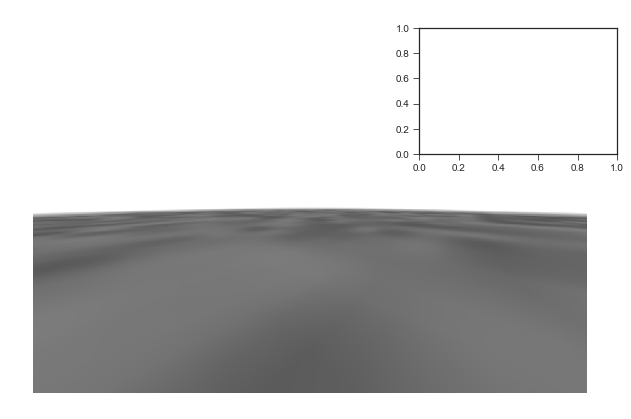

In [22]:
frameDirName = 'colTrajVRframes_v2'

try:
    mkdir(analysisDir + 'movieMaterial'+sep+frameDirName+sep)
except:
    print('directory already exists')

tstart = 11
tend = 11.5

frameRange = range(tstart*20*60,int(tend*20*60))

# select frames for VR video
frameratevr = 20
vrslctframes = np.linspace(0,int((tend-tstart)*60*frameratevr),int(20*60*(tend-tstart)))

# color code for time
cNorm  = colors.Normalize(vmin=0, vmax=len(frameRange))
mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
timeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

# color code for reinforcement
cNorm  = colors.Normalize(vmin=0, vmax=50)
evCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='hot')

xlimval = (np.min(xPos[frameRange]), np.max(xPos[frameRange]))
ylimval = (np.min(yPos[frameRange]), np.max(yPos[frameRange]))

import matplotlib.gridspec as gridspec
                                  
for iframe, frame in enumerate(frameRange):
    frameName = str(iframe)
    
    frameFig, framePlt = plt.subplots(1,1, figsize=(11,7))
    
    xpos = xPosTrial[frame]
    ypos = yPosTrial[frame]
    
    # compute distance to each landmark
    dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
    dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
    dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
    dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

    # compute distance to closest landmark
    dist2closestCone = np.minimum(dist2cone1,dist2cone2)
    dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

    entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
    entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
    
    # plot frame from video
    num=int(np.round(vrslctframes[iframe]))+1
    image = imageio.imread(analysisDir+'movieMaterial/'+vrFramesDir+sep+vrFramesStem+'_{}.jp'.format(str(num).zfill(6)))
    framePlt.imshow(image)
    framePlt.axis('off')
    
    #plot past trajectory
    framePlt = plt.axes([.65, .6, .25, .25], facecolor='w')
    #framePlt.scatter(xPosTrial[frameRange[0]:frame],yPosTrial[frameRange[0]:frame],s=3,c=np.arange(frameRange[0],frame),
    #             cmap=mycmap, vmin=frameRange[0], vmax=frameRange[-1], alpha=0.5)
    #framePlt.scatter(xPosTrial[frameRange[0]:frame],yPosTrial[frameRange[0]:frame],s=3,c=evTrial[frameRange[0]:frame],
    #             cmap='hot', vmin=0, vmax=50, alpha=0.5)
    
    # plot position
    plotBodyAngle(framePlt, xpos, ypos, angleFly[frame],'black', 0.6, 8)
    framePlt.plot(xpos,ypos,'.',color=evCMap.to_rgba(evTrial[frame]),markersize=12)

    if(entriesCone[frame]>0):
        framePlt.plot(xpos,ypos,'o',markersize=15, color=coneColor)
    
    if(entriesCyli[frame]>0):
        framePlt.plot(xpos,ypos,'o',markersize=15, color=cyliColor)
        
    #if(evTrial[frame]>0):
    #    framePlt.plot(xpos,ypos,'.',markersize=20,color='darkred')

    framePlt.plot(cyliCoords[0][0], cyliCoords[0][1], marker='s', markersize=8, alpha=0.6, color=cyliColor)
    framePlt.plot(coneCoords[0][0], coneCoords[0][1], marker='^', markersize=11, alpha=0.6, color=coneColor)
    framePlt.plot(coneCoords[1][0], coneCoords[1][1], marker='^', markersize=11, alpha=0.6, color=coneColor)
    framePlt.plot(cyliCoords[1][0], cyliCoords[1][1], marker='s', markersize=8, alpha=0.6, color=cyliColor)

    framePlt.set_xlim(0,120)
    framePlt.set_ylim(-60,60)
    framePlt.set_aspect('equal')
    
    framePlt.get_xaxis().set_visible(False)
    framePlt.get_yaxis().set_visible(False)
    plt.setp(framePlt.spines.values(), color='grey')
    
    #plot optogenetic stimulation
    framePlt = plt.axes([.13, .75, .1, .1], facecolor='none')
    framePlt.scatter(1,1,s=evTrial[frame]*30,c=evTrial[frame],cmap='hot', vmin=0, vmax=50, edgecolors='grey')
    framePlt.axis('off')

    #frameFig.tight_layout()
    frameFig.savefig(analysisDir + 'movieMaterial'+sep+frameDirName+sep+ genotype +'_'+flyIDs[0][0]
                       +'_all_fly'+ flyIDs[fly] +'_frame'+frameName.zfill(5)+'.jpeg', format='jpeg')
    
    plt.close("all")

### Version 3: non-collapsed trajectory with scene

In [50]:
coordFile = 'twoObjectForest_1cm4cmConeRZone1_08cm3cmCyliRZone2_6cmGrid_wn10000.coords'

# get object positions
visibleObjectCoords, visibleObjectName, invisibleObjectCoords, origin = loadObjectCoordIdentities(sep.join(dataDir.split(sep)[:-2])+sep, coordFile)
coneShape = np.asarray([bool('Cone' in objName) for objName in visibleObjectName])
cyliShape = np.asarray([bool('Cyli' in objName) for objName in visibleObjectName])

In [67]:
frameDirName = 'trajVRframes_vert'

try:
    mkdir(analysisDir + 'movieMaterial'+sep+frameDirName+sep)
except:
    print('directory already exists')

tstart = 11
tend = 11.5

frameRange = range(tstart*20*60,int(tend*20*60))

# select frames for VR video
frameratevr = 20
vrslctframes = np.linspace(0,int((tend-tstart)*60*frameratevr),int(20*60*(tend-tstart)))

# color code for time
cNorm  = colors.Normalize(vmin=0, vmax=len(frameRange))
mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
timeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

# color code for reinforcement
cNorm  = colors.Normalize(vmin=0, vmax=50)
evCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='hot')

xlimval = (np.min(x[frameRange]), np.max(x[frameRange]))
ylimval = (np.min(y[frameRange]), np.max(y[frameRange]))

import matplotlib.gridspec as gridspec
                                  
for iframe, frame in enumerate(frameRange):
    frameName = str(iframe)
    
    frameFig = plt.figure(figsize=(7,10))
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1])
    
    xpos = x[frame]
    ypos = y[frame]
    
    # compute distance to each landmark
    dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
    dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
    dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
    dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

    # compute distance to closest landmark
    dist2closestCone = np.minimum(dist2cone1,dist2cone2)
    dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

    entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
    entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
    
    #plot past trajectory
    framePlt = frameFig.add_subplot(gs[0,0])
    framePlt.scatter(x[frameRange[0]:frame],y[frameRange[0]:frame],s=7,c=evTrial[frameRange[0]:frame],
                 cmap='hot', vmin=0, vmax=50, alpha=0.5)
    
    # plot position
    plotBodyAngle(framePlt, xpos, ypos, angleFly[frame],'black', 0.6, 6)
    framePlt.plot(xpos,ypos,'.',color=evCMap.to_rgba(evTrial[frame]),markersize=20)

    framePlt.scatter(visibleObjectCoords[coneShape, 0], visibleObjectCoords[coneShape, 1], 80, alpha=0.8,
               facecolors=coneColor, edgecolors='none', marker = '^')
    framePlt.scatter(visibleObjectCoords[cyliShape, 0], visibleObjectCoords[cyliShape, 1], 80, alpha=0.8,
               facecolors=cyliColor, edgecolors='none', marker = 's')
    
    framePlt.set_xlim(xlimval[0]-50,xlimval[1]+50)
    framePlt.set_ylim(ylimval[0]-35,ylimval[1]+35)
    framePlt.set_aspect('equal')
    
    framePlt.set_title('Trajectory', fontsize=14)
    framePlt.get_xaxis().set_visible(False)
    framePlt.get_yaxis().set_visible(False)
    
    # plot frame from video
    framePlt = frameFig.add_subplot(gs[1,0])
    num=int(np.round(vrslctframes[iframe]))+1
    image = imageio.imread(analysisDir+'movieMaterial/'+vrFramesDir+sep+vrFramesStem+'_{}.jp'.format(str(num).zfill(6)))
    framePlt.set_title('Rendered VR scene', fontsize=14)
    framePlt.imshow(image)
    framePlt.get_xaxis().set_visible(False)
    framePlt.get_yaxis().set_visible(False)
    
    frameFig.tight_layout()
    frameFig.savefig(analysisDir + 'movieMaterial'+sep+frameDirName+sep+ genotype +'_'+flyIDs[0][0]
                       +'_all_fly'+ flyIDs[fly] +'_frame'+frameName.zfill(5)+'.jpeg', format='jpeg')
    
    plt.close("all")

directory already exists


## Make image of cylinder in matplotlib

In [255]:
def cylinder(R, nr, n, tmin, tmax):
    '''
    Returns the unit cylinder that corresponds to the curve r.
    INPUTS:  r - a vector of radii
             n - number of coordinates to return for each element in r

    OUTPUTS: x,y,z - coordinates of points
    '''

    # ensure that r is a column vector
    r = np.linspace(R, R,nr)
    r = np.atleast_2d(r)
    r_rows,r_cols = r.shape
    
    if r_cols > r_rows:
        r = r.T

    # find points along x and y axes
    points  = np.linspace(tmin,tmax,n+1)
    x = np.cos(points)*r
    y = np.sin(points)*r

    # find points along z axis
    rpoints = np.atleast_2d(np.linspace(0,1,len(r)))
    z = np.ones((1,n+1))*rpoints.T
    
    return x,y,z

Text(0.5,0,u'Z')

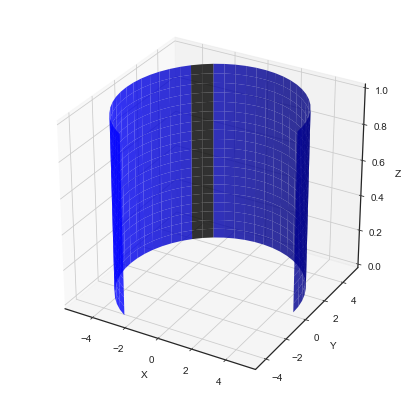

In [261]:
import mpl_toolkits.mplot3d.axes3d as p3

nr = 36
nh = 2

n=20

R = 5
H = 10

tmin = -0.9
tmax = 0.8

gap = 4.19
# get points from cylinder and plot
[X,Y,Z] = cylinder(R, n, nr, 0, gap)#, H, nh, -0.9, 0.8)

# generate face colors
oncol = 'b'
offcol = 'k'
colors = np.empty(X.shape, dtype=str)
stripeLoc = 18
for i in range(X.shape[0]):
    colors[i,:] = np.repeat(oncol, X.shape[1])
    colors[i,stripeLoc:stripeLoc+2] = offcol
    
# make plots
fig=plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z, color='grey',facecolors=colors, linewidth=0, alpha=0.8, antialiased=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')